In [2]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import scipy.io
import seaborn as sns
import pandas as pd
import re
import sys
# sys.path.append('../../Metaconnectivity/Python')
# from TS2dFCstream import TS2dFCstream
# from dFCstream2MC import dFCstream2MC
import itertools
import community as community_louvain
# from bct.algorithms import community_louvain
from bct.algorithms.centrality import participation_coef
import netsci.visualization as nsv
import netsci.metrics.motifs as nsm

## All functions

In [8]:
def degree_sequence(G):
    return [d for n, d in G.degree()]

def degree_distribution(G,normalize=True):
    deg_sequence = degree_sequence(G)
    max_degree = max(deg_sequence)
    ddist = np.zeros((max_degree+1,))
    for d in deg_sequence:
        ddist[d] += 1
    if normalize:
        ddist = ddist/float(G.number_of_nodes())
    return ddist

def cumulative_degree_distribution(G):
    ddist = degree_distribution(G)
    cdist = [ ddist[k:].sum()  for k in range(len(ddist)) ] 
    return cdist

def alpha_equation(G, kmin):
    a_tmp = [np.log(ki/(kmin - 0.5)) for ki in degree_sequence(G) if ki>=kmin]
    return 1+len(a_tmp)*(1/sum(a_tmp))

def sigma_equation(G,alpha, kmin):
    a_tmp = [np.log(ki/(kmin - 0.5)) for ki in degree_sequence(G) if ki>=kmin]
    return (alpha - 1) / np.sqrt(len(a_tmp))
def dist_cumu_plots(k, ddist, cdist):

    fig, (ax1, ax2)= plt.subplots(2, figsize=(8,12))
    ax1.bar(k,ddist, width=0.8, bottom=0, color='b') # replace xvalues and barheights!
    ax1.set_title('Degree distribution')
    
    ax2.loglog(k,cdist, label = 'original') # replace xvalues and yvalues!
    plt.legend() 
    plt.grid(True)
    x = np.log(k)
    y = np.log(cdist)
    m = (y[-1]-y[0])/(x[-1]-x[0])
    b = y[0]-m*x[0]
    ax2.loglog(np.exp(x), np.exp(m*x+b), label = 'linear_fitting')
    ax2.set_title('Power law fitting')


def calc_powerlaw(G,kmin=None):
    ddist = degree_distribution(G,normalize=True)
    cdist = cumulative_degree_distribution(G)
    k = np.arange(len(ddist))

    alpha = alpha_equation(G, kmin) # calculate using Newman (8.6)!
    sigma = sigma_equation(G, alpha, kmin) # calculate using Newman (8.7)!
    print( 'alpha: %1.2f +/- sigma: %1.2f' % (alpha,sigma) )
    dist_cumu_plots(k[kmin:],ddist[kmin:], cdist[kmin:])
    plt.legend() 
    plt.grid(True)

def degree_centrality(G, weight = None):
    if weight:
        return G.degree(weight=weight)
    else:
        return G.degree

def print_top_num(G,v, num=5):
    thenodes = list(G.nodes())
    idx_list = [(i,v[i]) for i in range(len(v))]
    idx_list = sorted(idx_list, key = lambda x: x[1], reverse=True)
    for i in range(min(num,len(idx_list))):
        nidx, score = idx_list[i]
        print('  %i. %s (%1.4f)' % (i+1,thenodes[nidx],score))

def scalar_assortativity(G,d):
    x = np.zeros(G.number_of_nodes())
    for i,n in enumerate(G.nodes()):
        x[i] = d[n]

    A = np.array(nx.adjacency_matrix(G).todense().T)
    M = 2*A.sum().sum()
    ki = A.sum(axis=1) #row sum is in-degree
    ko = A.sum(axis=0) #column sum is out-degree
    mu = ( np.dot(ki,x)+np.dot(ko,x) )/M

    R, Rmax = 0, 0
    for i in range(G.number_of_nodes()):
        for j in range(G.number_of_nodes()):
             R += ( A[i,j]*(x[i]-mu)*(x[j]-mu) )/M
             Rmax += ( A[i,j]*(x[i]-mu)**2 )/M

    return R, Rmax

def louvain_community(G):
    partition = community_louvain.best_partition(G)
    return partition

def part_coef(A, module_labels):
    part_coef = participation_coef(A, module_labels, degree='undirected')
    return part_coef



### Label information
SNC: super normal controls;  
NC: normal controls;  
MCI: mild cognitive impairments;  
AD: alzheimer's disease;  

In [3]:
# load groups subtab from mega_table.xlsx from data4project using pandas
group_caseid = pd.read_excel('../../data4project/mega_table.xlsx', sheet_name='groups')
print(group_caseid)
# read txt file sub_id.txt
id_with_group = np.loadtxt('./sub_id.txt', dtype='str')
labels = []
for index, id in enumerate(id_with_group[:74]):
    if id in group_caseid['caseid'].to_list():
        labels.append((group_caseid["group"][index], id))

    number group caseid
0        1   SNC  2820A
1        2   SNC  3168A
2        3   SNC  3358A
3        4   SNC  3610A
4        5   SNC  4073A
..     ...   ...    ...
69      70    AD  3255A
70      71    AD  4612A
71      72    AD  5368A
72      73    AD  5571A
73      74    AD  7673A

[74 rows x 3 columns]


### prepare parcellation

In [4]:
#load the parcellation data
file_name = '../../data4project/ROIs_512.xlsx'

df_parcel = pd.read_excel(file_name, sheet_name='Sheet1')
df_modules = pd.read_excel(file_name, sheet_name='Sheet2')
print(df_parcel)
print(df_modules)

                   Regions    Label_names  Label_id position
0    Temporal Pole Sup L.1       Temporal         1      L.1
1          Frontal Sup L.1        Frontal         2      L.1
2          Frontal Sup L.2        Frontal         2      L.2
3        SupraMarginal L.1  SupraMarginal        24      L.1
4             Fusiform L.1       Fusiform         7      L.1
..                     ...            ...       ...      ...
507          Precuneus R.8      Precuneus        16      R.8
508      Occipital Sup R.8      Occipital         5      R.8
509  Temporal Pole Mid R.5       Temporal         1      R.5
510        Precentral R.14     Precentral        21     R.14
511          Fusiform R.10       Fusiform         7     R.10

[512 rows x 4 columns]
            modules  ids
0          Temporal    1
1           Frontal    2
2          Parietal    3
3            Insula    4
4         Occipital    5
5           Caudate    6
6          Fusiform    7
7          Cingulum    8
8           Putamen

In [5]:
# create a communities dictionary, key is the Label_names, value is all the regions with the same label
c_communities = {}
for index, module in enumerate(df_modules['modules']):
    list_regions = df_parcel['Regions'][df_parcel['Label_names'] == module].to_list()
    c_communities[module] = *list_regions,
print(c_communities)

distance_communities = {}
for index, region in enumerate(df_parcel['Regions']):
    distance_communities[region]  = df_parcel["Label_id"][index]
print(distance_communities)

{'Temporal': ('Temporal Pole Sup L.1', 'Temporal Pole Mid L.1', 'Temporal Inf L.1', 'Temporal Pole Sup L.2', 'Temporal Sup L.1', 'Temporal Pole Sup L.3', 'Temporal Mid L.1', 'Temporal Inf L.2', 'Temporal Mid L.2', 'Temporal Sup L.2', 'Temporal Sup L.3', 'Temporal Inf L.3', 'Temporal Inf L.4', 'Temporal Inf L.5', 'Temporal Inf L.6', 'Temporal Inf L.7', 'Temporal Mid L.3', 'Temporal Pole Sup L.4', 'Temporal Mid L.4', 'Temporal Sup L.4', 'Temporal Inf L.8', 'Temporal Inf L.9', 'Temporal Mid L.5', 'Temporal Mid L.6', 'Temporal Mid L.7', 'Temporal Sup L.5', 'Temporal Mid L.8', 'Temporal Mid L.9', 'Temporal Inf L.10', 'Temporal Inf L.11', 'Temporal Mid L.10', 'Temporal Pole Mid L.2', 'Temporal Pole Sup L.5', 'Temporal Sup L.6', 'Temporal Mid L.11', 'Temporal Mid L.12', 'Temporal Mid L.13', 'Temporal Mid L.14', 'Temporal Sup L.7', 'Temporal Sup L.8', 'Temporal Mid L.15', 'Temporal Inf L.12', 'Temporal Pole Mid L.3', 'Temporal Pole Sup R.1', 'Temporal Sup R.1', 'Temporal Pole Mid R.1', 'Tempor

### load subjects

In [9]:
#load the single data
def select_network(id, visual = False):
    single_subj = scipy.io.loadmat(f'../../data4project/fmri_AAL_512/{id}/ROICorrelation_{id}.mat')
    return np.array(single_subj['ROICorrelation'])

# example cases
id1 = '0306A'
id2 = '7416A'
single_subj = select_network(id1)

### SKIP prepare names from each meta-links

In [7]:
# # combination set
# regions_combination = list(itertools.combinations(range(len(df_parcel.regions)), 2))
# # give labels to comba
# meta_links = []
# for x in regions_combination:
#     tmp_one = (regions[x[0]], regions[x[1]])
#     meta_links.append(tmp_one)
# meta_links = [str(i) for i in meta_links]
# print(meta_links)

### SKIP calculate metaconnectivity

In [8]:
# meta3d = np.zeros((len(meta_links), len(meta_links), len(group_caseid["group"])))

# def create_metaconnectivity(id):
#     single_subj = select_network(id)
#     # calculate the Metaconnectivity
#     dFCstream = TS2dFCstream(single_subj, 5, None, '2D')
#     # Calculate MC
#     return dFCstream2MC(dFCstream)


# for index, id in enumerate(group_caseid["caseid"]):
#     meta3d[:,:,index] = create_metaconnectivity(id)

In [6]:
fc3d = np.zeros((len(df_parcel.index), len(df_parcel.index), len(group_caseid["group"])))

In [10]:
for index, id in enumerate(group_caseid["caseid"]):
    fc3d[:,:,index] = select_network(id)
# average the meta3d based on label
SNC_fc = fc3d[:,:,:10].mean(axis=2)
NC_fc = fc3d[:,:,10:26].mean(axis=2)
MCI_fc = fc3d[:,:,26:61].mean(axis=2)
AD_fc = fc3d[:,:,61:].mean(axis=2)

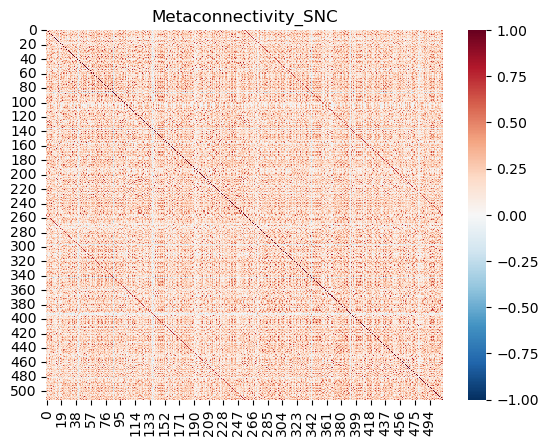

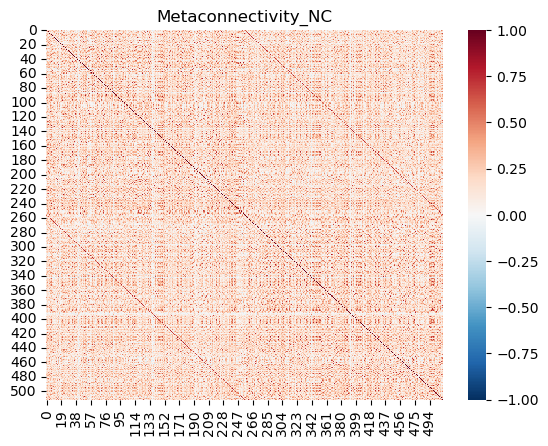

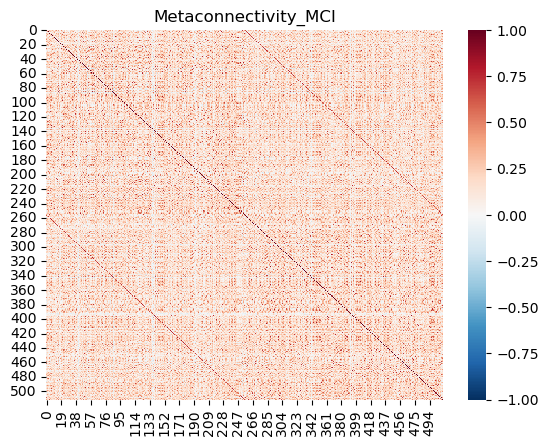

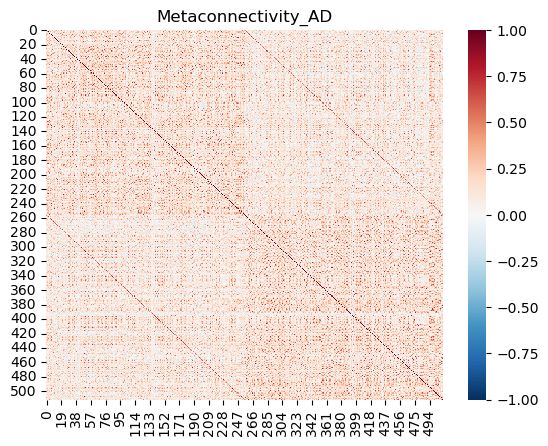

In [12]:
group_list = [SNC_fc, NC_fc, MCI_fc, AD_fc]
name_list = ['SNC', 'NC', 'MCI', 'AD']
for i in range(len(group_list)):
    sns.heatmap(group_list[i], cmap='RdBu_r', vmax = 1.0, vmin = -1.0, center = 0.0)
    plt.title(f'Metaconnectivity_{name_list[i]}')
    plt.show()

In [13]:
# build the network based on df_MC
def build_network(mean_MC, threshold):
    G = nx.Graph()
    for i in range(len(mean_MC)):
        for j in range(i+1, len(mean_MC)):
            if mean_MC[i,j] > threshold or mean_MC[i,j] < -threshold:
                G.add_edge(df_parcel.Regions[i], df_parcel.Regions[j], weight=mean_MC[i,j])
    return G
# build the network
thre = 0.5
G_AD = build_network(AD_fc, threshold=thre)
G_SNC = build_network(SNC_fc, threshold=thre)
G_NC = build_network(NC_fc, threshold=thre)
G_MCI = build_network(MCI_fc, threshold=thre)
# # relabel the nodes with meta_links
# G = nx.relabel_nodes(G, dict(zip(range(np.shape(meta3d)[0]), meta_links)))


In [ ]:
# nx.write_gml(G, 'fc_network.gml')

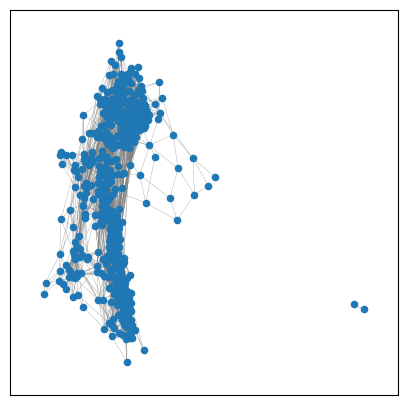

In [14]:
plt.figure(figsize=(5,5))
nx.draw_networkx(G_SNC, with_labels=False, node_size=20, width=0.2, edge_color='grey')

## Network Analysis

Functions used in the analyses

The workflow of analyses:
1. Node level  
    1. Weighted Degree Distribution
    2. Power-law
    3. Degree centrality  
    4. Eigenvector Centrality
    5. Average Neighbor Degree


2. Modularity level  
    1. Modularity and assotativity  
    2. Louvain community detection  
        1. Integration: Participation coefficient (identify the global intermodular `integration`.)
        2. Segregation: clustering coefficient.


3. Network level
    1. Large components
    2. Network Similarity
        1. Motif, building block of the network
        2. Graphlet, calculate the similarity between groups

Some analyses not applicable:

1. FC is correlation based analyses, which means that all the path based analyses are not applicable, including network integration, closeness centrality, betweenness centrality. 
2. However, we can use length of correlation to explore the influence of the one nodes to the other nodes. 
3. The similarity of the network will be measured by motif and graphlet.

### 1.1 Degree distribution and 1.2 power-law

alpha: 1.94 +/- sigma: 0.04


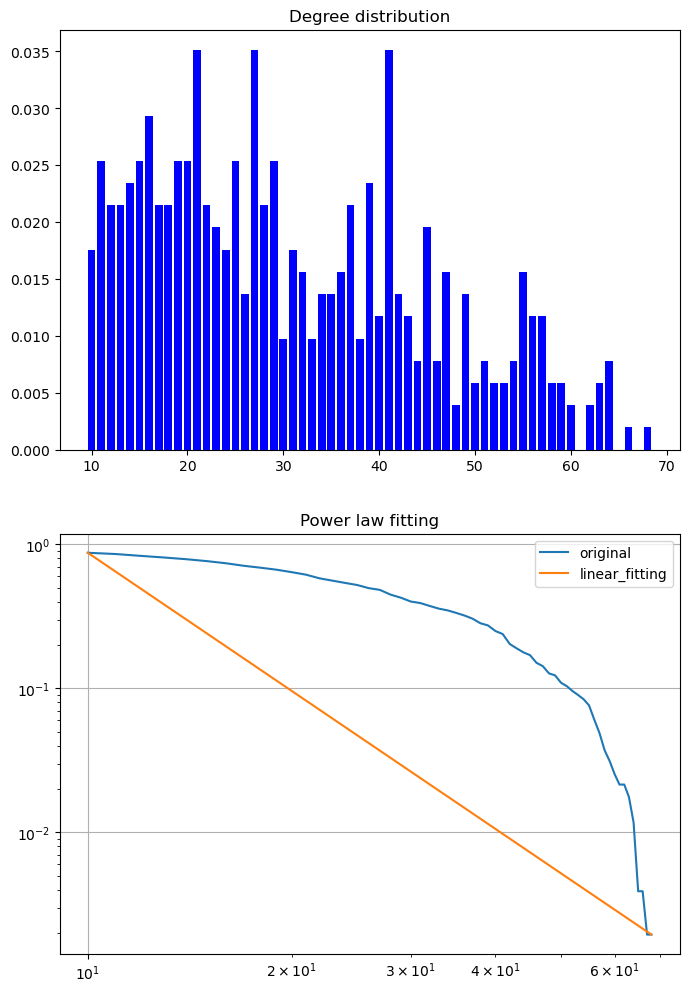

In [15]:
calc_powerlaw(G_SNC,kmin=10) # select kmin!

### 1.3 Degree centrality

In [16]:
centrality_vector = [val for (node, val) in G_SNC.degree(weight='weight')]
print('degree centrality, unweigted:')
print_top_num(G_SNC, centrality_vector, num=10)

degree centrality, unweigted:
  1. Precentral R.11 (40.5724)
  2. Parietal Sup L.8 (40.1854)
  3. Postcentral R.9 (39.8222)
  4. Occipital Mid L.12 (39.2306)
  5. Fusiform L.7 (39.1502)
  6. Supp Motor Area L.2 (39.1397)
  7. Parietal Sup L.5 (39.0520)
  8. Paracentral Lobule R.1 (38.7891)
  9. Fusiform R.10 (38.5343)
  10. Occipital Mid L.1 (37.5561)


### 1.4 Eigenvector centrality

In [17]:
eigencentrality_vector = [i for i in nx.eigenvector_centrality(G_AD, weight='weight', max_iter=10000).values()]
print(f'Eigenvector Centrality weighted:')
print_top_num(G_AD, eigencentrality_vector, num=10)

Eigenvector Centrality weighted:
  1. Occipital Mid R.1 (0.2151)
  2. Occipital Mid L.1 (0.1925)
  3. Lingual R.5 (0.1915)
  4. Lingual L.5 (0.1878)
  5. Calcarine L.3 (0.1863)
  6. Occipital Mid R.7 (0.1780)
  7. Lingual R.6 (0.1732)
  8. Occipital Sup R.7 (0.1700)
  9. Occipital Sup R.5 (0.1658)
  10. Occipital Mid R.2 (0.1657)


### 1.5 Average neighbor degree

In [18]:
# create a function to calculate the average neighbor degree of each node
def average_neighbor_degree(G):
    average_neighbor_degree = []
    for node in G.nodes():
        average_neighbor_degree.append(nx.average_neighbor_degree(G, nodes=[node], weight='weight')[node])
    return average_neighbor_degree

average_neighbor_degree_vector = average_neighbor_degree(G_AD)
print(f'Averaging neighor degree, weighted:')
print_top_num(G_AD, average_neighbor_degree_vector, num=10)

Averaging neighor degree, weighted:
  1. Calcarine R.1 (32.5979)
  2. Lingual R.6 (32.4705)
  3. Calcarine L.1 (32.4146)
  4. Occipital Mid L.9 (32.2739)
  5. Cuneus L.3 (31.8576)
  6. Lingual R.5 (31.8429)
  7. Calcarine L.3 (31.8400)
  8. Occipital Mid L.2 (31.8334)
  9. Fusiform R.4 (31.8070)
  10. Lingual L.5 (31.7293)


## Modularity level

### 2.1 Modularity & Scalar Associativity

In [19]:
# Linear Trends
nx.community.modularity(G_AD, c_communities.values())

0.43016098165690825

In [20]:
def make_d_scalar(G, df_parcel):
    d_communities = {}
    for index, region in enumerate(df_parcel['Regions']):

        d_communities[region] = G.degree(region, weight='weight')
    return d_communities
d_communities = make_d_scalar(G_AD, df_parcel)

In [21]:
# Linear Trends
R, Rmax = scalar_assortativity(G_SNC, d=distance_communities)
print(R/Rmax)

0.37430910610201606


/var/folders/s2/p1qgp3rx7wz63mc5wkrqb7yw0000gp/T/ipykernel_76484/2924939160.py:74: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = np.array(nx.adjacency_matrix(G).todense().T)


### 2.2 Louvain community detection
2.2.1 Integration: Participation coefficient

In [22]:
group_key = G_AD
def compute_partition_from_louvain(G, mode="part_coef", part_coef_threshold=0.5):
    partition = nx.community.louvain_communities(group_key, seed =42)
    # plt.figure(figsize=(5,5))
    # nx.draw_networkx(G_AD, with_labels=False, node_size=20, width=0.2, edge_color='grey', node_color=list(partition.values()))
    if mode in ["modularity", "modularity_louvain"]:
        modularity_louvain = nx.community.modularity(group_key, partition)
        return modularity_louvain
    else:
        # matching the partition with the df_parcel
        partition_number = np.zeros(group_key.number_of_nodes())
        for index, i in enumerate(partition):
            subset = [ix for ix in i]
            for ix in subset:
                # return the index of the region
                all_subset_nodes = df_parcel[df_parcel['Regions'] == ix].index[0]
                partition_number[all_subset_nodes] = index
        A = np.array(nx.adjacency_matrix(group_key).todense().T)
        part_coef = participation_coef(A, partition_number)
        return np.array(group_key.nodes)[np.where(part_coef<part_coef_threshold)]
part_nodes_names = compute_partition_from_louvain(group_key)
print(part_nodes_names)

['Thalamus L.4' 'Putamen L.1' 'Frontal Inf Oper L.1'
 'Temporal Pole Sup L.4' 'Putamen L.2' 'Parietal Inf L.4' 'Rectus L.1'
 'Cingulum Ant R.2' 'Frontal Inf Tri L.4' 'Frontal Inf Orb L.2'
 'Thalamus L.3' 'Cingulum Mid L.2' 'Frontal Mid L.15' 'Cingulum Ant L.3'
 'Cingulum Ant R.3' 'Precentral L.5' 'Cingulum Mid R.3' 'Cingulum Mid R.5']


/var/folders/s2/p1qgp3rx7wz63mc5wkrqb7yw0000gp/T/ipykernel_76484/3255771675.py:18: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = np.array(nx.adjacency_matrix(group_key).todense().T)


### 2.2.2 Average clustering coefficient

In [23]:
# nx.transitivity(G_AD)
print(nx.average_clustering(G_AD))

0.4811947944244295


## 3 Network Level

3.1 large components

### 3.2 Network Similarity

In [47]:
H = G_AD.subgraph([i for i in list(G_AD.nodes())[:10]])
print(H.edges())

[('Temporal Pole Sup L.5', 'Temporal Pole Sup L.1'), ('Paracentral Lobule L.2', 'Frontal Sup L.1'), ('Frontal Mid L.8', 'Frontal Sup L.1'), ('Frontal Mid L.8', 'Frontal Mid L.4'), ('Frontal Inf Orb L.3', 'Temporal Pole Sup L.1'), ('Frontal Inf Orb L.3', 'Olfactory L.1'), ('Frontal Inf Orb L.3', 'Temporal Pole Mid L.3'), ('Frontal Sup L.1', 'Frontal Mid L.4'), ('Frontal Sup L.1', 'Supp Motor Area L.3'), ('Temporal Pole Sup L.1', 'Olfactory L.1'), ('Temporal Pole Sup L.1', 'Temporal Pole Mid L.3'), ('Olfactory L.1', 'Temporal Pole Mid L.3')]


### 3.2.1 Motif

/var/folders/s2/p1qgp3rx7wz63mc5wkrqb7yw0000gp/T/ipykernel_76484/108318235.py:4: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = A = nx.adjacency_matrix(G_SNC, weight=None).todense().T


[[0 1 1 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[18829378        0  3256443        0        0        0        0        0
        0        0   103320        0        0        0        0    49579]
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16]


[<Axes: >, <Axes: >]

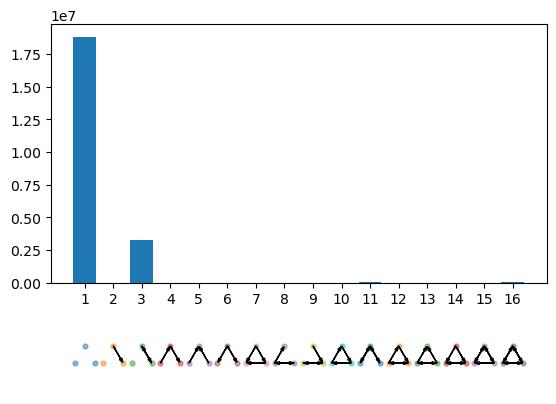

In [59]:


A = A = nx.adjacency_matrix(G_SNC, weight=None).todense().T
print(A)
f = nsm.motifs(A, algorithm='brute-force' )
print(f)
nsv.bar_motifs(f)

### 3.2.2 Graphlets

In [17]:
nx.write_edgelist(G_AD, "AD.csv", data=False, delimiter=",")
nx.write_edgelist(G_SNC, "SNC.csv", data=False, delimiter=",")
nx.write_edgelist(G_NC, "NC.csv", data=False, delimiter=",")
nx.write_edgelist(G_MCI, "MCI.csv", data=False, delimiter=",")

In [ ]:
### I will use a python script called "OrbitalFeatures" to extract the features from the network